In [2]:
from textblob import TextBlob
import numpy as np
import pandas as pd
import nltk
pd.options.display.max_columns = None
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from feature_engine.preprocessing import MatchVariables
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.imputation import (
    AddMissingIndicator, MeanMedianImputer, CategoricalImputer, EndTailImputer
)
from feature_engine.transformation import PowerTransformer
from feature_engine.creation import RelativeFeatures
from feature_engine.selection import DropFeatures
plt.style.use('ggplot')
train = pd.read_csv('/Users/manu/Analisis Predictivo/Exámen 2/analisis-predictivo-2023q1/base_train.csv')
val = pd.read_csv('/Users/manu/Analisis Predictivo/Exámen 2/analisis-predictivo-2023q1/base_val.csv')

df = pd.concat([train, val], join='outer')

#La variable a predecir es review_scores_rating.

In [3]:
df.head(3)

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,528022,city scrape,Somewhere Else,Highlights<br />*Located only 5 minutes from C...,NaN,2594559,Els,2012-06-10,"Amsterdam, Netherlands",NaN,within a day,87%,96%,f,Spaarndammer en Zeeheldenbuurt,1,1,"['email', 'phone']",t,t,NaN,Westerpark,NaN,52.39114,4.88846,Private room in boat,Private room,2,NaN,1.5 baths,1.0,1.0,"[""Bed linens"", ""Dishes and silverware"", ""Hange...",$100.00,2,30,2,2,30,30,2.0,30.0,NaN,t,4,16,29,212,2022-12-05,248,37,3,2016-10-06,2022-11-28,4.85,4.88,4.83,4.93,4.90,4.78,4.72,0363 9289 A94D 5C21 A579,f,1,0,1,0,3.30
1,2818,city scrape,Quiet Garden View Room & Super Fast Wi-Fi,Quiet Garden View Room & Super Fast Wi-Fi<br /...,"Indische Buurt (""Indies Neighborhood"") is a ne...",3159,Daniel,2008-09-24,"Amsterdam, Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,100%,t,Indische Buurt,1,1,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,NaN,52.36435,4.94358,Private room in rental unit,Private room,2,NaN,1.5 shared baths,1.0,2.0,"[""Books and reading material"", ""Smoke alarm"", ...",$59.00,3,28,3,3,1125,1125,3.0,1125.0,NaN,t,6,27,27,27,2022-12-05,314,29,1,2009-03-30,2022-11-06,4.89,4.93,4.99,4.97,4.98,4.69,4.81,0363 5F3A 5684 6750 D14D,f,1,0,1,0,1.88
2,20168,previous scrape,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,59484,Alexander,2009-12-02,"Amsterdam, Netherlands",+ (Phone number hidden by Airbnb),within an hour,100%,98%,f,Grachtengordel,3,5,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Centrum-Oost,NaN,52.36407,4.89393,Private room in townhouse,Private room,2,NaN,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Hangers"", ""Wifi...",$106.00,1,365,1,1,1125,1125,1.0,1125.0,NaN,t,0,0,0,0,2022-12-05,339,0,0,2010-03-02,2020-04-09,4.44,4.69,4.79,4.63,4.62,4.87,4.49,0363 CBB3 2C10 0C2A 1E29,t,2,0,2,0,2.18


# EDA

In [35]:
df.info()
#Elimino tres columnas que solo contienen valores nulos y el id.
df = df.drop(['calendar_updated', 'bathrooms', 'neighbourhood_group_cleansed'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6161 entries, 0 to 1232
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6161 non-null   int64  
 1   source                                        6161 non-null   object 
 2   name                                          6161 non-null   object 
 3   description                                   6157 non-null   object 
 4   neighborhood_overview                         4159 non-null   object 
 5   host_id                                       6161 non-null   int64  
 6   host_name                                     6161 non-null   object 
 7   host_since                                    6161 non-null   object 
 8   host_location                                 5518 non-null   object 
 9   host_about                                    3751 non-null   o

In [36]:
#Chequeo de duplicados
df.duplicated().sum()
#La base no tiene ninguno

0

In [37]:
#Descripcion Estadistica
df.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6.161000e+03,6.161000e+03,6161.000000,6161.000000,6161.000000,6161.000000,6161.000000,5893.000000,6084.000000,6161.000000,6161.000000,6161.000000,6161.000000,6.161000e+03,6.161000e+03,6161.000000,6.161000e+03,6161.000000,6161.000000,6161.000000,6161.000000,6161.000000,6161.000000,6161.000000,4928.000000,6157.000000,6157.000000,6157.000000,6157.000000,6157.000000,6157.000000,6161.000000,6161.000000,6161.000000,6161.000000,6161.000000
mean,1.205147e+17,9.269425e+07,2.386788,4.492777,52.366999,4.890538,2.902938,1.557441,1.864070,4.533680,457.033112,4.347509,5.038955,3.491511e+05,3.491807e+05,4.658724,3.491715e+05,5.009739,13.123194,21.546502,81.127739,53.048693,12.557539,0.940269,4.812330,4.848670,4.760789,4.880387,4.890471,4.790138,4.650797,1.836715,0.971109,0.769843,0.042363,1.226475
std,2.565406e+17,1.264804e+08,9.657741,26.422596,0.016870,0.035412,1.370015,0.868844,1.527575,31.864749,504.988261,31.815624,32.049137,2.735925e+07,2.735925e+07,31.936655,2.735925e+07,7.459386,17.240099,27.737741,112.089136,103.234578,31.079845,2.857436,0.264727,0.233881,0.316494,0.216868,0.221001,0.247403,0.305070,2.521715,1.299529,2.091714,0.454048,2.335964
min,2.818000e+03,3.159000e+03,1.000000,1.000000,52.290340,4.755710,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.385264e+07,9.010909e+06,1.000000,1.000000,52.356370,4.867350,2.000000,1.000000,1.000000,2.000000,21.000000,2.000000,2.000000,2.800000e+01,3.000000e+01,2.000000,3.000000e+01,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,4.750000,4.790000,4.670000,4.850000,4.870000,4.670000,4.510000,1.000000,0.000000,0.000000,0.000000,0.280000
50%,3.025028e+07,3.114623e+07,1.000000,1.000000,52.366290,4.888226,2.000000,1.000000,1.000000,3.000000,100.000000,2.000000,3.000000,3.650000e+02,1.000000e+03,3.000000,9.990000e+02,1.000000,4.000000,6.000000,19.000000,16.000000,4.000000,0.000000,4.880000,4.920000,4.860000,4.950000,4.970000,4.860000,4.700000,1.000000,1.000000,0.000000,0.000000,0.610000
75%,5.066769e+07,1.244073e+08,2.000000,3.000000,52.376650,4.908510,4.000000,2.000000,2.000000,3.000000,1125.000000,3.000000,4.000000,1.125000e+03,1.125000e+03,3.800000,1.125000e+03,8.000000,24.000000,40.000000,135.000000,48.000000,10.000000,1.000000,4.990000,5.000000,5.000000,5.000000,5.000000,5.000000,4.830000,1.000000,1.000000,1.000000,0.000000,1.410000
max,7.700956e+17,4.889846e+08,363.000000,673.000000,52.425120,5.026430,16.000000,10.000000,33.000000,1001.000000,1825.000000,1001.000000,1001.000000,2.147484e+09,2.147484e+09,1001.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,1875.000000,1352.000000,139.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,22.000000,14.000000,20.000000,8.000000,106.740000


## Conversión de columnas

Tengo que elegir de que manera quiero transformar mis variables categoricas a numericas.
- One-Hot Encoding: me genera una variable dummy por cada categoria, donde 1 indica que si y 0 que no.
- Label Encoding: me genera una sola variable nueva, donde cada número indica uno de los valores categoricos.

In [38]:
#Source: tiene dos categorias (dos fuentes). 0 = City Scrape y 1 = Previous Scrape. 
#Se pisa source y con la codificada.
df.source.value_counts()
encoder = LabelEncoder()
df['source'] = encoder.fit_transform(df['source'])

Para el caso del **nombre** (*name*), la **descripción** (*description*) y el **detalle del barrio** (*neighborhood_overview*) de la publicación, se pueden generar varias columnas que permitan generar valor a ambas columnas y permitan incluirlas en el modelo. 
1. En primer lugar, se va a generar una columna donde se guarde la longitud del texto.
2. Luego, se va a realizar un análisis de sentimiento de la palabra, utilizando la libreria TextBlob, donde esta va a asignar un valor de sentimiento a cada palabra (previamente tokenizada). Esto puede ser una puntuación entre -1 y 1, donde valores negativos indican un sentimiento negativo, valores cercanos a cero indican neutralidad y valores positivos indican un sentimiento positivo. Para obtener el puntaje total del nombre, se suman los valores de cada palabra.

In [39]:
#name: El nombre de la publicación. Hay algunos pocos que se repiten. 
#Varios análisis a realizar.
df.name.value_counts()

#Impacto de la longitud:
df['name_length'] = df['name'].apply(len)

#Análisis de sentimiento: 
names = df['name']
clean_names = names.str.replace('[^\w\s]','').str.lower().str.split()
sentiments = []
for name in clean_names:
    sentiment = 0
    for word in name:
        sentiment += TextBlob(word).sentiment.polarity
    sentiments.append(sentiment)
#Agregar los puntajes de sentimiento como una nueva columna al dataframe
df['name_sentiment'] = sentiments



/var/folders/q_/r_vc8qlx2gjgzy57nd_nrykw0000gn/T/ipykernel_27617/1838430666.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_names = names.str.replace('[^\w\s]','').str.lower().str.split()


In [40]:
#description: descripción de la publicación.
#Varios análisis a realizar.
df['description'].replace(np.nan, '', inplace=True) #Para incluir a los 4 valores vacios.
df.description.value_counts()

#Impacto de la longitud:
df['description_length'] = df['description'].apply(len)

#Análisis de sentimiento: 
description = df['description']
# Limpiar los textos y tokenizar las palabras
clean_description = description.str.replace('[^\w\s]','').str.lower().str.split()
# Crear una lista para almacenar los puntajes de sentimiento de cada publicación
sentiments = []
# Asignar un puntaje de sentimiento a cada palabra y sumarlos para cada publicación
for desc in clean_description:
    sentiment = 0
    for word in desc:
        sentiment += TextBlob(word).sentiment.polarity
    sentiments.append(sentiment)
# Agregar los puntajes de sentimiento como una nueva columna al dataframe
df['description_sentiment'] = sentiments

/var/folders/q_/r_vc8qlx2gjgzy57nd_nrykw0000gn/T/ipykernel_27617/2555409218.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_description = description.str.replace('[^\w\s]','').str.lower().str.split()


In [41]:
#neighborhood_overview: descripción de la locación de la publicación.
df['neighborhood_overview'].replace(np.nan, '', inplace=True) #Para incluir a los 4 valores vacios.
df.neighborhood_overview.value_counts()

#Impacto de la longitud:
df['neighborhood_overview_length'] = df['neighborhood_overview'].apply(len)

#Análisis de sentimiento: 
neighborhood_overview = df['neighborhood_overview']
# Limpiar los textos y tokenizar las palabras
clean_neighborhood_overview = neighborhood_overview.str.replace('[^\w\s]','').str.lower().str.split()
# Crear una lista para almacenar los puntajes de sentimiento de cada publicación
sentiments = []
# Asignar un puntaje de sentimiento a cada palabra y sumarlos para cada publicación
for over in clean_neighborhood_overview:
    sentiment = 0
    for word in over:
        sentiment += TextBlob(word).sentiment.polarity
    sentiments.append(sentiment)
# Agregar los puntajes de sentimiento como una nueva columna al dataframe
df['neighborhood_overview_sentiment'] = sentiments

/var/folders/q_/r_vc8qlx2gjgzy57nd_nrykw0000gn/T/ipykernel_27617/3183778232.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_neighborhood_overview = neighborhood_overview.str.replace('[^\w\s]','').str.lower().str.split()


In [42]:
#host_name: nombre del host de la publicación.
df.host_name.value_counts()

#Categorizar los nombres según la letra en la que comienzan:
def get_first_letter(name):
    return name[0].upper()
df['host_name_first_letter'] = df['host_name'].apply(get_first_letter)
df.host_name_first_letter.value_counts()

#Utilizo la libreria gender_guesser para reconocer si el host es hombre o mujer.
import gender_guesser.detector as gender
d = gender.Detector()
#Función para predecir género
def predict_gender(name):
    gender = d.get_gender(name)
    if gender == 'male':
        return 'Male'
    elif gender == 'female':
        return 'Female'
    if pd.isna(name):
        return 'Missing'
    else:
        return 'Unknown'
# Aplicar la función a la columna 'host_name'
df['predicted_gender'] = df['host_name'].apply(predict_gender)

In [43]:
#host_since: desde cuando esta el host en Airbnb. Mide la antiguedad. La quiero pasar a cuantos dias de antiguedad llevan.
from datetime import date
df['host_since'] = pd.to_datetime(df['host_since'])
target_date = pd.to_datetime('2022-12-05')
df['host_since'] = (target_date - df['host_since']).dt.days

In [44]:
#host_location: Localización del host. Busco saber si reside o no en Holanda y en Amsterdam.
#Función para clasificar los valores
def classify_location(location):
    if pd.isna(location):
        return 'Missing'
    elif 'Amsterdam' in str(location):
        return 'Amsterdam'
    elif 'Netherlands' in str(location):
        return 'Netherlands'
    else:
        return 'Other'

#Aplicar la función a la columna 'host_location'
df['host_location'] = df['host_location'].apply(classify_location)

In [45]:
#host_about: Descripción sobre el host.
df.host_about.value_counts()
df['host_about'].replace(np.nan, '', inplace=True) #Para incluir a los 4 valores vacios.
#Impacto de la longitud:
df['host_about_length'] = df['host_about'].apply(len)

#Análisis de sentimiento: 
host_about = df['host_about']
# Limpiar los textos y tokenizar las palabras
clean_host_about = host_about.str.replace('[^\w\s]','').str.lower().str.split()
# Crear una lista para almacenar los puntajes de sentimiento de cada publicación
sentiments = []
# Asignar un puntaje de sentimiento a cada palabra y sumarlos para cada publicación
for over in clean_host_about:
    sentiment = 0
    for word in over:
        sentiment += TextBlob(word).sentiment.polarity
    sentiments.append(sentiment)
# Agregar los puntajes de sentimiento como una nueva columna al dataframe
df['host_about_sentiment'] = sentiments

/var/folders/q_/r_vc8qlx2gjgzy57nd_nrykw0000gn/T/ipykernel_27617/3408465268.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_host_about = host_about.str.replace('[^\w\s]','').str.lower().str.split()


In [46]:
#host_response_time: Cuanto tarda en responder. 4 categorias.
df.host_response_time.value_counts()


within an hour        2440
within a day           904
within a few hours     885
a few days or more      69
Name: host_response_time, dtype: int64

In [6]:
#host_neighbourhood: Donde vive el host. Me es relevante si vive en la zona donde esta el apartamento(?)
df.host_neighbourhood.value_counts()
df['same_neighbourhood'] = df.apply(lambda row: 't' if row['host_neighbourhood'] ==
                                    row['neighbourhood_cleansed'] else 'f', axis=1)

df.same_neighbourhood.value_counts()
#Hay 221 hosts que viven en el mismo barrio.

f    5940
t     221
Name: same_neighbourhood, dtype: int64

In [48]:
#host_identity_verified: Si está verificado el host.
df.host_identity_verified.value_counts()

#871 sin verificar. Raro.

t    5290
f     871
Name: host_identity_verified, dtype: int64

In [49]:
#neighbourhood: Región donde está el apartamento.
df.neighbourhood.value_counts()

#Mayoritariamente refiere a la ciudad, con diferentes maneras. Se va a eliminar ya que no suma información al análisis.
df = df.drop('neighbourhood', axis=1)

In [50]:
#property_type: Tipo de propiedad con descripción. Muchas diferentes.
df.property_type.value_counts()

Entire rental unit                    2211
Entire condo                          1061
Private room in rental unit            495
Entire home                            378
Private room in bed and breakfast      282
Entire townhouse                       195
Entire loft                            166
Houseboat                              124
Private room in condo                  122
Private room in home                   120
Room in boutique hotel                 107
Private room in houseboat              102
Private room in guest suite             96
Private room in townhouse               88
Room in hotel                           88
Boat                                    77
Entire serviced apartment               66
Private room in boat                    56
Private room in loft                    40
Room in bed and breakfast               26
Entire guest suite                      23
Shared room in hostel                   23
Room in aparthotel                      18
Private roo

In [51]:
#room_type: Tipo de habitación. 4 categorias.
df.room_type.value_counts()

Entire home/apt    4388
Private room       1679
Hotel room           57
Shared room          37
Name: room_type, dtype: int64

In [52]:
#bathrooms_text: Texto sobre los baños. 21 distintos. Se encuentran números + si es compartido. 
#Voy a generar una variable de cantidad y una variable que categorice si son compartidos, privados o no hay.
df.bathrooms_text.value_counts()

import re
df['bathrooms_number'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
df['bathrooms_number'] = df['bathrooms_number'].fillna(0.5) #Ya que los que no tenian numero, decian half_bath.

#Función para clasificar los valores
def classify_bath(bath):
    if 'shared' in str(bath).lower():
        return 'shared'
    else:
        return 'private'
#Aplicar la función a la columna 'host_location'
df['bathrooms_type'] = df['bathrooms_text'].apply(classify_bath)
df.loc[df['bathrooms_number'] == 0, 'bathrooms_type'] = 'none'

In [53]:
#amenities: Las amenities de la propiedad. Decido contarlas.
df.amenities.value_counts()
df['amenities_count'] = df['amenities'].str.count(',') + 1

In [54]:
#price: El precio de la propiedad. Le quito el $.
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '').astype(float)

/var/folders/q_/r_vc8qlx2gjgzy57nd_nrykw0000gn/T/ipykernel_27617/1371983206.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '')


In [55]:
#first_review y last_review: Cuento los dias tambien.
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

target_date = pd.to_datetime('2022-12-05')
df['first_review'] = (target_date - df['first_review']).dt.days
df['last_review'] = (target_date - df['last_review']).dt.days

In [56]:
#host_response_rate y host_acceptance_rate: Sacar el porcentaje.
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
df['host_response_rate'] = df['host_response_rate'].astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '')
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float)

In [57]:
df[['review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
'review_scores_communication', 'review_scores_location',
       'review_scores_value']] = df[['review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].astype(float)

## Missings

In [58]:
print('El tamaño del dataframe es de: '+ str(df.shape))
total = df.isnull().sum().sort_values(ascending=False)
perc = round(total/6161*100, 2)
missing_data = pd.concat([total, perc], axis = 1, keys = ['Total', 'Percent'])
print(missing_data[total != 0])

El tamaño del dataframe es de: (6161, 78)
                             Total  Percent
host_neighbourhood            3195    51.86
host_response_time            1863    30.24
host_response_rate            1863    30.24
review_scores_rating          1233    20.01
host_acceptance_rate           816    13.24
bedrooms                       268     4.35
license                        120     1.95
beds                            77     1.25
bathrooms_text                   9     0.15
review_scores_communication      4     0.06
review_scores_value              4     0.06
review_scores_accuracy           4     0.06
review_scores_cleanliness        4     0.06
review_scores_location           4     0.06
review_scores_checkin            4     0.06
host_is_superhost                1     0.02


In [59]:
#df.select_dtypes(include=['object']).columns
df = df.drop(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_location', 'host_about', 'host_neighbourhood', 'host_verifications',
       'neighbourhood_cleansed',
       'bathrooms_text', 'amenities',
       'calendar_last_scraped', 'license'], axis = 1)

In [60]:
df.head(3)

,id,source,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,name_length,name_sentiment,description_length,description_sentiment,neighborhood_overview_length,neighborhood_overview_sentiment,host_name_first_letter,predicted_gender,host_about_length,host_about_sentiment,same_neighbourhood,bathrooms_number,bathrooms_type,amenities_count
0,528022,0,2594559,3830,within a day,87.0,96.0,f,1,1,t,t,52.39114,4.88846,Private room in boat,Private room,2,1.0,1.0,100.0,2,30,2,2,30,30,2.0,30.0,t,4,16,29,212,248,37,3,2251,7,4.85,4.88,4.83,4.93,4.90,4.78,4.72,f,1,0,1,0,3.30,14,0.000000,1000,3.216667,0,0.0000,E,Unknown,0,0.000000,f,1.5,private,20
1,2818,0,3159,5185,within an hour,100.0,100.0,t,1,1,t,t,52.36435,4.94358,Private room in rental unit,Private room,2,1.0,2.0,59.0,3,28,3,3,1125,1125,3.0,1125.0,t,6,27,27,27,314,29,1,4998,29,4.89,4.93,4.99,4.97,4.98,4.69,4.81,f,1,0,1,0,1.88,41,0.533333,1000,0.258730,954,0.9950,D,Male,329,0.750000,f,1.5,shared,44
2,20168,1,59484,4751,within an hour,100.0,98.0,f,3,5,t,t,52.36407,4.89393,Private room in townhouse,Private room,2,1.0,1.0,106.0,1,365,1,1,1125,1125,1.0,1125.0,t,0,0,0,0,339,0,0,4661,970,4.44,4.69,4.79,4.63,4.62,4.87,4.49,t,2,0,2,0,2.18,44,0.000000,1000,1.087500,561,0.8125,A,Male,33,-0.166667,f,1.0,private,16


In [61]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

categorical_columns = [c for c in df.columns if df[c].dtype == 'object']
numerical_columns = [c for c in df.columns if c not in categorical_columns and c != 'review_scores_rating' and c != 'id']

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OrdinalEncoder())
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

df2 = df

df2[categorical_columns] = categorical_pipeline.fit_transform(df2[categorical_columns])
df2[numerical_columns] = numerical_pipeline.fit_transform(df2[numerical_columns])

df2.head()



/Users/manu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


,id,source,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,name_length,name_sentiment,description_length,description_sentiment,neighborhood_overview_length,neighborhood_overview_sentiment,host_name_first_letter,predicted_gender,host_about_length,host_about_sentiment,same_neighbourhood,bathrooms_number,bathrooms_type,amenities_count
0,528022,0.0,2594559.0,3830.0,2.0,87.0,96.0,1.0,1.0,1.0,1.0,1.0,52.39114,4.88846,20.0,2.0,2.0,1.0,1.0,100.0,2.0,30.0,2.0,2.0,30.0,30.0,2.0,30.0,1.0,4.0,16.0,29.0,212.0,248.0,37.0,3.0,2251.0,7.0,4.85,4.88,4.83,4.93,4.90,4.78,4.72,0.0,1.0,0.0,1.0,0.0,3.30,14.0,0.000000,1000.0,3.216667,0.0,0.000000,5.0,2.0,0.0,0.000000,0.0,1.5,1.0,20.0
1,2818,0.0,3159.0,5185.0,4.0,100.0,100.0,2.0,1.0,1.0,1.0,1.0,52.36435,4.94358,34.0,2.0,2.0,1.0,2.0,59.0,3.0,28.0,3.0,3.0,1125.0,1125.0,3.0,1125.0,1.0,6.0,27.0,27.0,27.0,314.0,29.0,1.0,4998.0,29.0,4.89,4.93,4.99,4.97,4.98,4.69,4.81,0.0,1.0,0.0,1.0,0.0,1.88,41.0,0.533333,1000.0,0.258730,954.0,0.995000,4.0,1.0,329.0,0.750000,0.0,1.5,2.0,44.0
2,20168,1.0,59484.0,4751.0,4.0,100.0,98.0,1.0,3.0,5.0,1.0,1.0,52.36407,4.89393,37.0,2.0,2.0,1.0,1.0,106.0,1.0,365.0,1.0,1.0,1125.0,1125.0,1.0,1125.0,1.0,0.0,0.0,0.0,0.0,339.0,0.0,0.0,4661.0,970.0,4.44,4.69,4.79,4.63,4.62,4.87,4.49,1.0,2.0,0.0,2.0,0.0,2.18,44.0,0.000000,1000.0,1.087500,561.0,0.812500,1.0,1.0,33.0,-0.166667,0.0,1.0,1.0,16.0
3,27886,0.0,97647.0,4640.0,4.0,100.0,100.0,2.0,1.0,1.0,1.0,1.0,52.38761,4.89188,31.0,2.0,2.0,1.0,1.0,140.0,2.0,356.0,2.0,2.0,1125.0,1125.0,2.0,1125.0,1.0,0.0,17.0,32.0,40.0,243.0,17.0,5.0,3983.0,8.0,4.94,4.93,4.95,4.95,4.92,4.89,4.79,1.0,1.0,0.0,1.0,0.0,1.83,49.0,0.500000,1000.0,7.264286,42.0,1.716667,6.0,1.0,228.0,0.552381,0.0,1.5,1.0,52.0
4,28871,0.0,124245.0,4589.0,3.0,100.0,100.0,2.0,2.0,2.0,1.0,1.0,52.36775,4.89092,34.0,2.0,2.0,1.0,1.0,75.0,2.0,1825.0,2.0,2.0,1825.0,1825.0,2.0,1825.0,1.0,0.0,3.0,8.0,91.0,454.0,84.0,7.0,4488.0,15.0,4.88,4.93,4.89,4.95,4.94,4.97,4.83,0.0,2.0,0.0,2.0,0.0,3.03,23.0,0.400000,704.0,2.455952,44.0,0.000000,5.0,1.0,2.0,0.000000,0.0,1.0,2.0,20.0


In [62]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6161 entries, 0 to 1232
Data columns (total 65 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6161 non-null   int64  
 1   source                                        6161 non-null   float64
 2   host_id                                       6161 non-null   float64
 3   host_since                                    6161 non-null   float64
 4   host_response_time                            6161 non-null   float64
 5   host_response_rate                            6161 non-null   float64
 6   host_acceptance_rate                          6161 non-null   float64
 7   host_is_superhost                             6161 non-null   float64
 8   host_listings_count                           6161 non-null   float64
 9   host_total_listings_count                     6161 non-null   f

In [63]:
#Guardo la base para usarla:
df2.to_csv('df.csv', index=False)

## Modelo de Regresión Lineal Simple

Valores de las predicciones:
[4.94275304 4.94275304 4.68153367 ... 4.63451418 4.9166311  4.91140671]


/Users/manu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


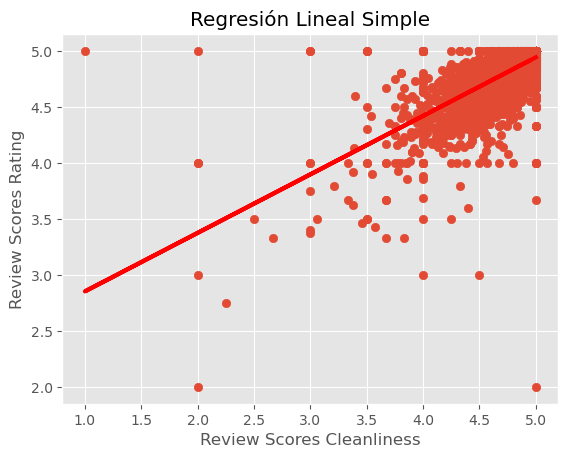

DATOS DEL MODELO REGRESIÓN LINEAL SIMPLE

Valor de la pendiente o coeficiente "a":
[0.52243874]
Valor de la intersección o coeficiente "b":
2.3305593528366804

La ecuación del modelo es igual a:
y =  [0.52243874] x + 2.3305593528366804


In [170]:
from sklearn import linear_model
train=df.dropna(subset=['review_scores_cleanliness', 'review_scores_rating'])
# Separar las características y la variable objetivo para el conjunto de entrenamiento
X_train = train[['review_scores_cleanliness']]
y_train = train['review_scores_rating']

# Crear el modelo de regresión lineal y ajustarlo a los datos de entrenamiento
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

# Predecir en el conjunto de validación
val = df.loc[df['review_scores_rating'].isna(), ['id', 'review_scores_cleanliness']]
#val = df[df['review_scores_rating'].isna()]['review_scores_cleanliness']
X_val = val['review_scores_cleanliness'].values.reshape(-1,1)
y_pred = lr.predict(X_val)

# Imprimir las predicciones en el conjunto de validación
print('Valores de las predicciones:')
print(y_pred)

plt.scatter(X_train, y_train)
plt.plot(X_val, y_pred, color='red', linewidth=3)
plt.title('Regresión Lineal Simple')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Review Scores Rating')
plt.show()

print('DATOS DEL MODELO REGRESIÓN LINEAL SIMPLE')
print()
print('Valor de la pendiente o coeficiente "a":')
print(lr.coef_)
print('Valor de la intersección o coeficiente "b":')
print(lr.intercept_)
print()
print('La ecuación del modelo es igual a:')
print('y = ', lr.coef_, 'x +', lr.intercept_)

y_pred = pd.DataFrame(y_pred)
submission = pd.concat([val, y_pred], axis=1)
del submission['review_scores_cleanliness']
submission = submission.rename(columns={0: 'review_scores_rating'})
submission

# Save to CSV file
#submission.to_csv('submission.csv', index=False)

## Modelo de Regresión Lineal Multiple

In [201]:
from sklearn import linear_model
train=df.dropna(subset=['review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy' ,'review_scores_rating', 'description_sentiment'])
# Separar las características y la variable objetivo para el conjunto de entrenamiento
X_train = train[['review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy', 'description_sentiment']]
y_train = train['review_scores_rating']

# Crear el modelo de regresión lineal y ajustarlo a los datos de entrenamiento
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

# Predecir en el conjunto de validación
val = df.loc[df['review_scores_rating'].isna(), ['id', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy', 'description_sentiment']]
X_val = val[['review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy', 'description_sentiment']]
y_pred = lr.predict(X_val)

# Imprimir las predicciones en el conjunto de validación
print('Valores de las predicciones:')
print(y_pred)


y_pred = pd.DataFrame(y_pred)
submission = pd.concat([val, y_pred], axis=1)
del submission['review_scores_cleanliness']
del submission['review_scores_location']
del submission['review_scores_accuracy']
del submission['description_sentiment']

submission = submission.rename(columns={0: 'review_scores_rating'})
submission

# Save to CSV file
submission.to_csv('submission.csv', index=False)

Valores de las predicciones:
[4.968429   4.97137691 4.04812935 ... 4.61716227 4.90713596 4.9464378 ]


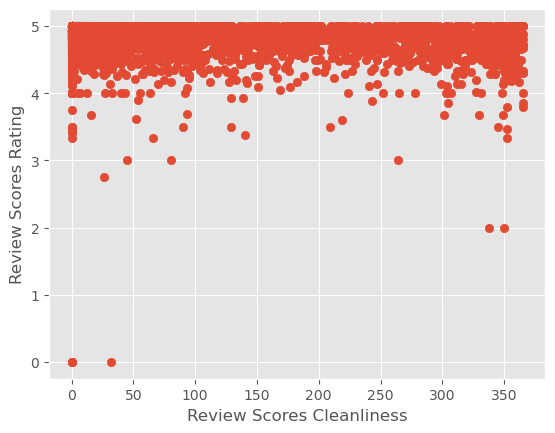

In [183]:
train=df.dropna(subset=['availability_365', 'review_scores_rating'])
# Separar las características y la variable objetivo para el conjunto de entrenamiento
X_train = train[['availability_365']]
y_train = train['review_scores_rating']
#Graficamos los datos correspondientes
plt.scatter(X_train, y_train)
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Review Scores Rating')
plt.show()

In [193]:
correlations = df.corr()
correlations['review_scores_rating']  -0.2

id                                              False
source                                          False
host_id                                         False
host_listings_count                             False
host_total_listings_count                       False
latitude                                        False
longitude                                       False
accommodates                                    False
bedrooms                                        False
beds                                            False
minimum_nights                                  False
maximum_nights                                  False
minimum_minimum_nights                          False
maximum_minimum_nights                          False
minimum_maximum_nights                          False
maximum_maximum_nights                          False
minimum_nights_avg_ntm                          False
maximum_nights_avg_ntm                          False
availability_30             

In [1013]:
df.corr()['review_scores_rating']

id                      0.012046
source                  0.089363
host_id                -0.176212
host_since              0.151125
host_response_time     -0.106135
                          ...   
host_about_sentiment   -0.012763
same_neighbourhood      0.006280
bathrooms_number        0.059483
bathrooms_type         -0.059599
amenities_count         0.166238
Name: review_scores_rating, Length: 64, dtype: float64

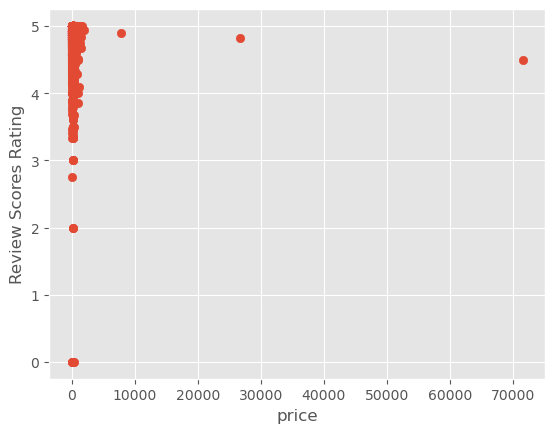

In [1021]:
X_train = df['price']
y_train = df['review_scores_rating']
#Graficamos los datos correspondientes
plt.scatter(X_train, y_train)
plt.xlabel('price')
plt.ylabel('Review Scores Rating')
plt.show()